# CA census housing data

The goal of this project is to predict the location of a median house value in California based on census parameters, such as median age, income, and average population of a region.

We will use both classification and regression algorithms to fit our data, though I suspect regression algorithms will lead to a better fit.

## Importing and preprocessing the data

### Importing the data

I will be working with a [dataset available on kaggle](https://www.kaggle.com/camnugent/california-housing-prices). The housing data collected from the 1990 census.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
# Import the kaggle dataset
house = pd.read_csv('housing.csv')
# Drop any row that contains NaN values
housing = house.dropna(axis=0)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Preprocessing

As I don't have official training in natural language processing, I will get rid of the *ocean_proximity* column, and assess the longitude and latitude based only on the numerical values of the remaining input parameters.

In [2]:
housing2 = housing.drop('ocean_proximity', axis=1)
housing2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


It is unclear at this point what algorithms we will be using to fit our data. Many algorithms require normalized data to function properly, so let's go ahead and normalize each column of data. To do this, I will divide each column by it's maximum value (or minimum in the case of longitude).

In [3]:
housing3 = housing2.copy()
housing3.housing_median_age = housing3.housing_median_age/housing3.housing_median_age.max()
housing3.total_rooms = housing3.total_rooms/housing3.total_rooms.max()
housing3.total_bedrooms = housing3.total_bedrooms/housing3.total_bedrooms.max()
housing3.population = housing3.population/housing3.population.max()
housing3.households = housing3.households/housing3.households.max()
housing3.median_income = housing3.median_income/housing3.median_income.max()
housing3.median_house_value = housing3.median_house_value/housing3.median_house_value.max()
housing3.longitude = housing3.longitude/housing3.longitude.min()
housing3.latitude = housing3.latitude/housing3.latitude.max()
housing3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,0.982951,0.902980,0.788462,0.022380,0.020016,0.009024,0.020717,0.555010,0.905198
1,0.982871,0.902503,0.403846,0.180544,0.171606,0.067289,0.187110,0.553423,0.716999
2,0.983032,0.902265,1.000000,0.037309,0.029480,0.013901,0.029102,0.483823,0.704199
3,0.983112,0.902265,1.000000,0.032401,0.036462,0.015638,0.036008,0.376204,0.682599
4,0.983112,0.902265,1.000000,0.041378,0.043445,0.015834,0.042585,0.256412,0.684399
...,...,...,...,...,...,...,...,...,...
20635,0.973784,0.941120,0.480769,0.042345,0.058029,0.023681,0.054258,0.104019,0.156200
20636,0.974749,0.941359,0.346154,0.017726,0.023274,0.009977,0.018744,0.170452,0.154200
20637,0.974829,0.939928,0.326923,0.057325,0.075252,0.028222,0.071194,0.113333,0.184600
20638,0.975633,0.939928,0.346154,0.047304,0.063460,0.020767,0.057382,0.124479,0.169400


## Fitting the data

Now that our data contains normalized parameters, it is time to try different algorithms that will attempt to predict the median house value.

Unless stated otherwise, I will split our 20433 data points into a training set and test set, with a 75/25 split respectively.

### Linear Regression with ridge, lasso, and elastic net

The median house value is unlikely to be a linear combination of our input variables, but it is a good place to start for simplicity.

Linear regression attempts to minimize the sum of the absolute error of each coefficient used in fitting the model. Lasso regression also includes a second term to be minimized, alpha times the absolute magnitude of each input parameter. This allows the parameters weight to be zero for input parameters with negligible influence.

Ridge regression also utilizes a least squares fitting and penalty feature. The Ridge regression penalty feature is alpha times the input parameter squared. This second term cannot be zero, however it should still reduce the model complexity.

In both cases, the alpha factor controls how much each individual input parameter has on our output parameters, instead of assuming the sum of squares for each parameter should be equally weighted.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lrmodel = LinearRegression().fit(X_train, y_train)
lrmodelpredicttrain = lrmodel.predict(X_train)
lrmodelpredicty = lrmodel.predict(X_test)
print("The fit score for linear model on training data is", r2_score(lrmodelpredicttrain, y_train))
print("The fit score for linear model on test data is", r2_score(lrmodelpredicty, y_test))
'''
plt.scatter(range(0,len(y_test)), y_test, label='True test value')
plt.scatter(range(0,len(lrmodelpredicty)), lrmodelpredicty, label='Predicted test value')
plt.legend()
plt.xlabel('index')
plt.ylabel('ave hous price')
'''

The fit score for linear model on training data is 0.429422589442498
The fit score for linear model on test data is 0.4142418047384244


"\nplt.scatter(range(0,len(y_test)), y_test, label='True test value')\nplt.scatter(range(0,len(lrmodelpredicty)), lrmodelpredicty, label='Predicted test value')\nplt.legend()\nplt.xlabel('index')\nplt.ylabel('ave hous price')\n"

As we suspected, a simple linear model doesn't seem to fit our dataset very well. Let's give the Ridge regression a try and see if that improves our fit quality.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create empty dictionary to store fit scores in, convert to dataframe at end
ridgefits = {}

# List of alpha values
alpha = [0.0001,0.001,0.01,0.1,1,10]
dummyweight = {}
for i in alpha:
    ridgemodel = Ridge(alpha = i).fit(X_train, y_train)
    ridgemodelpredicttrain = ridgemodel.predict(X_train)
    ridgemodelpredicty = ridgemodel.predict(X_test)
    # Dictionary is train: test
    ridgefits[i] = [r2_score(ridgemodelpredicttrain, y_train), r2_score(ridgemodelpredicty, y_test)]
    dummyweight[i] = ridgemodel.coef_[0]

dummydata = pd.DataFrame.from_dict(ridgefits).T
dummyfits = dummydata.rename(columns = {0 : 'Training', 1 : 'Test'})
dummydata = pd.DataFrame.from_dict(dummyweight).T
ridgeweights = dummydata.rename(columns={0 : 'long weight', 1 : 'lat weight', 2 : 'housing_median_age weight', 
                                         3 : 'total_rooms weight', 4 : 'total_bedrooms weight', 5 : 'population weight', 
                                         6 : 'households weight', 7 : 'median_income weight'})
ridgeweights['Training'] = dummyfits.Training
ridgeweights['Test'] = dummyfits.Test
ridgeweights

,long weight,lat weight,housing_median_age weight,total_rooms weight,total_bedrooms weight,population weight,households weight,median_income weight,Training,Test
0.0001,10.740944,-3.588182,0.123431,-0.611730,1.488216,-2.577095,0.461844,1.202239,0.429392,0.414209
0.0010,10.717718,-3.581132,0.123594,-0.613079,1.487029,-2.576328,0.464048,1.202635,0.429117,0.413912
0.0100,10.490923,-3.512288,0.125189,-0.626194,1.475465,-2.568645,0.485391,1.206489,0.426391,0.410966
0.1000,8.662250,-2.956891,0.138148,-0.726989,1.384353,-2.490950,0.643833,1.237149,0.401517,0.384057
1.0000,3.181598,-1.286162,0.179306,-0.859441,1.069142,-1.877755,0.843254,1.312691,0.282230,0.254539
10.0000,0.410605,-0.401378,0.202266,-0.232306,0.424943,-0.526648,0.365549,1.250059,0.074272,0.032159


Increasing our $\alpha$ factor decreases our quality of fit, as represented by the $r^2$ test value dropping as $\alpha$ increases.

It is worth noting that the fit is best when:
- longitude is strongly weighted
- median income, househoulds and total_bedrooms are weakly weighted
- latitude and population are weakly negatively weighted

Again, our fit isn't great, so let's try the lasso regression.

In [8]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

# Create empty dictionary to store fit scores in, convert to dataframe at end
lassofits = {}

# List of alpha values
alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1]
dummyweight = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for i in alpha:
    lassomodel = Lasso(alpha = i, max_iter=2000).fit(X_train, y_train)
    lassomodelpredicttrain = lassomodel.predict(X_train)
    lassomodelpredicty = lassomodel.predict(X_test)
    # Dictionary is train: test
    lassofits[i] = [r2_score(lassomodelpredicttrain, y_train), r2_score(lassomodelpredicty, y_test)]
    dummyweight[i] = lassomodel.coef_
dummydata = pd.DataFrame.from_dict(lassofits).T
dummyfits = dummydata.rename(columns = {0 : 'Training', 1 : 'Test'})
dummydata = pd.DataFrame.from_dict(dummyweight).T
lassoweights = dummydata.rename(columns={0 : 'long weight', 1 : 'lat weight', 2 : 'housing_median_age weight', 
                                         3 : 'total_rooms weight', 4 : 'total_bedrooms weight', 5 : 'population weight', 
                                         6 : 'households weight', 7 : 'median_income weight'})
lassoweights['Training'] = dummyfits.Training
lassoweights['Test'] = dummyfits.Test
lassoweights

,long weight,lat weight,housing_median_age weight,total_rooms weight,total_bedrooms weight,population weight,households weight,median_income weight,Training,Test
0.000001,10.705008,-3.577162,0.123717,-0.608799,1.484115,-2.571203,0.461149,1.202384,4.287209e-01,0.413472
0.000010,10.358201,-3.470852,0.126457,-0.584256,1.446860,-2.516935,0.456425,1.204134,4.222555e-01,0.406391
0.000100,6.888669,-2.406735,0.153874,-0.346551,1.087773,-1.966618,0.398263,1.222461,3.423450e-01,0.319722
0.001000,0.000000,-0.007777,0.177447,0.000000,0.175418,-0.000000,0.000000,1.227564,-5.086316e-02,-0.095766
0.010000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.630302,-4.339055e+00,-4.530819
0.100000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-1.727857e+31,0.000000


Lasso quickly quashes all input parameters down to zero weight. This isn't extrodinarily helpful.

Let's try one last combination of ridge and lasso by applying the elastic net algorithm. Elastic net regression attempts to minimize the least squares regression, and both correction factors provided by Lasso and Ridge.

Here $\alpha$ is similar to the Lasso error correction parameter. The l1 ratio correction parameters can vary between 0 and 1. When the l1 parameter is set to zero, the penalty is an L2 penalty. For l1 parameter = 1, the penalty is an L1 penalty.

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

# Create empty dictionary to store fit scores in, convert to dataframe at end
netfits = {}

X_train, X_test, y_train, y_test = train_test_split(X, y)

alpha = [0.000001, 0.00001, 0.0001]

l1 = np.logspace(-3,0,10, base=10)
for i in alpha:
    # Create/reset a counter for l1 loop
    l1fits = {}
    for _ in l1:
        netmodel = ElasticNet(alpha = i, l1_ratio = _, max_iter=6000).fit(X_train, y_train)
        netmodelpredicttrain = netmodel.predict(X_train)
        netmodelpredicty = netmodel.predict(X_test)
        # Dictionary is train: test
        l1fits[_] = [r2_score(netmodelpredicttrain, y_train), r2_score(netmodelpredicty, y_test)]
    netfits[i] = l1fits
allnetfits = pd.DataFrame.from_dict(netfits)
allnetfits.index.name = 'l1 ratio'
allnetfits.columns.name = 'alpha'
allnetfits

alpha,0.000001,0.000010,0.000100
l1 ratio,,,
0.001000,"[0.42791788608690096, 0.3928168742576158]","[0.3921898379741442, 0.35383678661682916]","[0.25258744878352013, 0.20237298029140882]"
0.002154,"[0.42792228672743193, 0.3928216845899686]","[0.39222152021175294, 0.35387119857455285]","[0.25261764613099713, 0.2024058447704672]"
0.004642,"[0.4279317681860212, 0.3928320486992247]","[0.39228982219292474, 0.3539453849188261]","[0.2526829147655588, 0.20247683840870667]"
0.010000,"[0.427952198087888, 0.39285438051217847]","[0.39243718372894376, 0.3541054456590208]","[0.2528245733907465, 0.20263070021671759]"
0.021544,"[0.4279962257869149, 0.39290250779586744]","[0.3927556364857163, 0.35445134746720663]","[0.25313737655573443, 0.2029676688397215]"
0.046416,"[0.4280911393231007, 0.3930062605094642]","[0.3934462685510218, 0.35520155202483816]","[0.2538195829464822, 0.20370839490853032]"
0.100000,"[0.42829589790667355, 0.3932300976545766]","[0.39495558705488676, 0.3568412331525772]","[0.2553699516171234, 0.20539264242000854]"
0.215443,"[0.42873830749248987, 0.39371377588190826]","[0.3983097303921741, 0.360486068820408]","[0.2591505755078102, 0.20950109936841832]"
0.464159,"[0.429697344791654, 0.3947624782384457]","[0.4060428595208484, 0.36889524592485057]","[0.2703177934154475, 0.2216215876165395]"


The above table values can be read as (training $r^2$ value, test $r^2$ value).

There is no significant change in the fit as we vary the l1 ratio. Increasing the alpha correction factor quickly degrades the fit, similar to what we observed in the Lasso only fits.

As we suspected, linear fits of our input parameters are not great predictors for the median housing value.

### K Nearest Neighbor

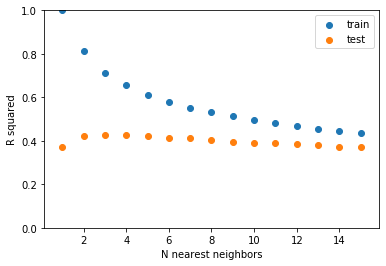

,Training,Test
1,1.000000,0.373488
2,0.811184,0.424235
3,0.713603,0.425102
4,0.655582,0.424833
5,0.610369,0.419887
6,0.580213,0.412902
7,0.552503,0.413893
8,0.530952,0.403537
9,0.513216,0.394408
10,0.496661,0.391319


In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y)

knnfits = {}
dummyweight = {}
neighbors = np.linspace(1,15,15, dtype='int')
for i in neighbors:
    knnmodel = KNeighborsRegressor(n_neighbors = i).fit(X_train, y_train)
    knnmodelpredicttrain = knnmodel.predict(X_train)
    knnmodelpredicty = knnmodel.predict(X_test)
    # Dictionary is train: test
    knnfits[i] = [r2_score(knnmodelpredicttrain, y_train), r2_score(knnmodelpredicty, y_test)]
dummydata = pd.DataFrame.from_dict(knnfits).T
dummyfits = dummydata.rename(columns = {0 : 'Training', 1 : 'Test'})

plt.scatter(neighbors, dummyfits.Training, label='train')
plt.scatter(neighbors, dummyfits.Test, label='test')
plt.legend(loc=0)
plt.xlabel("N nearest neighbors")
plt.ylabel("R squared")
plt.ylim(0,1)
plt.show()
dummyfits

The KNN model has a slightly higher fit than our linear regression for 2-4 neighbors. I might be able to acheive better results by running the model many times with different seeds, but the fit value is still low enough that I think we should try other methods.

### Polynomial Regression

Polynomial fitting allows for higher-order and coupled input parameter weights to be a factor in determining the final fit. For instance, while *households* may not correlate strongly to our desired result, perhaps $(households)^2$ does, or $households \cdot population$. Polynomial fitting allows us to test non-linear combinations of our input parameters, and determine their relative weights to median housing value.

Let's try fitting our data to different polynomials of first through fifth degree.

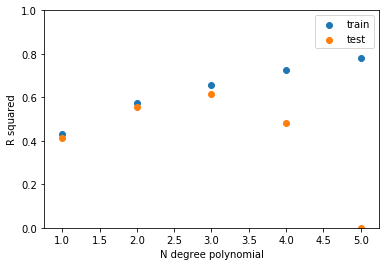

,R squared
N degree Polynomial,
1,0.414242
2,0.554849
3,0.613410
4,0.482877
5,0.000905


In [26]:
# Now let's try higher order fits using polynomials
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

degree = []
polymodpredictiontrainlist = []
polymodpredictylist = []

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y)

for i in range(1,6):
    degree.append(i)
    poly = PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(x_poly,y, random_state=0)

    polymodel = LinearRegression().fit(X_train, y_train)
    polymodelpredicttrain = polymodel.predict(X_train)
    polymodelpredicty = polymodel.predict(X_test)
    polymodpredictiontrainlist.append(r2_score(polymodelpredicttrain, y_train))
    polymodpredictylist.append(r2_score(polymodelpredicty, y_test))
    #print(polymodelpredicty, y_test

plt.scatter(degree, polymodpredictiontrainlist, label='train')
plt.scatter(degree, polymodpredictylist, label='test')
plt.legend(loc=0)
plt.xlabel("N degree polynomial")
plt.ylabel("R squared")
plt.ylim(0,1)
plt.show()
pd.Series(polymodpredictylist, index = range(1,6))

polyfits = pd.DataFrame(list(zip(polymodpredictylist, range(1,8))), columns = ['R squared', 'N degree Polynomial'])
polyfits = polyfits.set_index('N degree Polynomial')
polyfits

It looks like a 3rd degree polynomial has managed to fit our test data better than any previous model. While the fit on the training data continues to increase past this point, this is due to overfitting, and leads to a decrease in the test fit.

Let's quickly try the elastic net on our 3rd degree polynomial to see if we can increase our fit even more.

In [27]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(X)
# Create empty dictionary to store fit scores in, convert to dataframe at end
netfits = {}

X_train, X_test, y_train, y_test = train_test_split(x_poly, y)

alpha = [0.000001,0.00001,0.0001]
l1 = np.logspace(-3,0,10, base=10)
for i in alpha:
    l1fits = {}
    for _ in l1:
        netmodel = ElasticNet(alpha = i, l1_ratio = _, max_iter=4000).fit(X_train, y_train)
        netmodelpredicttrain = netmodel.predict(X_train)
        netmodelpredicty = netmodel.predict(X_test)
        # Dictionary is train: test
        l1fits[_] = [r2_score(netmodelpredicttrain, y_train), r2_score(netmodelpredicty, y_test)]
    netfits[i] = l1fits
allnetfits = pd.DataFrame.from_dict(netfits)
allnetfits.index.name = 'l1 ratio'
allnetfits.columns.name = 'alpha'
allnetfits

C:\Users\preston\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.97524585901917, tolerance: 0.08217053229002265
  positive)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.95660797959441, tolerance: 0.08217053229002265
  positive)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.91646575850517, tolerance: 0.08217053229002265
  positive)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

alpha,0.000001,0.000010,0.000100
l1 ratio,,,
0.001000,"[0.582314262974504, 0.5738542712588965]","[0.5527647025923492, 0.5447629551457976]","[0.4844207624547515, 0.47892672097331856]"
0.002154,"[0.582320896013659, 0.5738611741964329]","[0.552756092163762, 0.5447522163031139]","[0.48432605869454426, 0.47883614956589193]"
0.004642,"[0.582335216152275, 0.5738760802330347]","[0.5527374776189218, 0.5447290035886889]","[0.4841220452970493, 0.4786415145972327]"
0.010000,"[0.5823662296179275, 0.5739083969261685]","[0.5526970184269003, 0.5446785794466167]","[0.483680607415072, 0.47822138959103166]"
0.021544,"[0.5824343081006622, 0.5739788848588838]","[0.5526079940784066, 0.544568389485597]","[0.4827240408907384, 0.4773048592143363]"
0.046416,"[0.5825815432786748, 0.5741338055515732]","[0.5524023962094365, 0.5443156152242273]","[0.48064655491702934, 0.47530698999097654]"
0.100000,"[0.5829256976355197, 0.5744917346134939]","[0.5520126329343444, 0.5438068101447429]","[0.47610345470299087, 0.47097220280925023]"
0.215443,"[0.5837178789055043, 0.57527519450733]","[0.5511148451965615, 0.5426779427357327]","[0.4663337031279362, 0.461825007887233]"
0.464159,"[0.5859171866043658, 0.5773920077385873]","[0.5493991075451043, 0.5404981912860309]","[0.44695938886746045, 0.4441904802024027]"


The above table values can be read as (training $r^2$ value, test $r^2$ value).

Similar to what we saw previously, our fit values in our test set are more or less invariant over the l1 ratio, and decrease as alpha increases.

At this point, without more iterations, we've capped out our polynomial regression capabilities. We did see an improvement over the linear regression, but let us continue to explore algorithms.

### Support vector machines

It is possible that a few datapoints are causing a large skew to our fitted models, and linear regression fitting techniques are poorly suited for this data set. In order to accomodate for larger margins of error for individual data points, we are going to try support vector machines to fit our data set.

It is important to note that support vector regression analysis does not actually transform the data when it evaluates fits, thus it is computationally less intensive than polynomial regression.

The C value in the SVR controls the strength of regularization. Large C values fit the training data as well as possible (less regularization), while smaller C values are more tolerant of errors in individual data points (more regularization). C must be positive, and the strength of the squared l2 penalty is inversely proportional to C.

The $\gamma$ factor determines the similarity factor for data points. Large $\gamma$ increases the influence of other nearby data points.

In [31]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = housing3.iloc[:,:-1]
y = housing3.iloc[:,-1:]

# Create empty dictionary to store fit scores in, convert to dataframe at end
svrfits = {}

#lat fit
X_train, X_test, y_train, y_test = train_test_split(X, y)

cvalues = np.logspace(-1,2,4, base=10)
gammavalues = np.logspace(-2,0,3, base=10)
for i in cvalues:
    gammavaluesfits = {}
    for _ in gammavalues:
        svrmodel = SVR(kernel = 'rbf', C = i, gamma = _).fit(X_train, y_train)
        svrmodelpredicttrain = svrmodel.predict(X_train)
        svrmodelpredicty = svrmodel.predict(X_test)
        # Dictionary is train: test
        gammavaluesfits[_] = [r2_score(svrmodelpredicttrain, y_train), r2_score(svrmodelpredicty, y_test)]
    svrfits[i] = gammavaluesfits
allsvrfits = pd.DataFrame.from_dict(svrfits)
allsvrfits.index.name = 'gamma value'
allsvrfits.columns.name = 'C value'
allsvrfits

C:\Users\preston\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\preston\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C value,0.1,1.0,10.0,100.0
gamma value,,,,
0.01,"[-1.29532985591604, -1.222443518049067]","[0.04616501860538735, 0.08824709506991735]","[0.27032593185418863, 0.3067276648170797]","[0.40600709515289635, 0.437643298060976]"
0.10,"[0.049063514033386935, 0.09248956874244507]","[0.28567015177815924, 0.3222071943600171]","[0.4464853439788723, 0.4742427758143626]","[0.5196552845944109, 0.5437471162849646]"
1.00,"[0.33553573581465257, 0.3751024924325286]","[0.5035809516283947, 0.5316752324810166]","[0.5753101098424249, 0.5934472135014823]","[0.6071019662752006, 0.6216608587038421]"


The above table values can be read as (training $r^2$ value, test $r^2$ value).